In [235]:
from collections import Counter

from sklearn.decomposition import PCA

from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

import pandas as pd
import seaborn as sns
import glob
import numpy as np
import matplotlib as mpl
# Some preprocessing utilities
from sklearn.cross_validation import train_test_split # Data splitting
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
# Model result function
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import preprocessing
from sklearn.utils import shuffle
import itertools
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

sns.set_context('paper',font_scale=2.)
sns.set_style("ticks",)
palette = sns.plt.cm.gray_r
# set masked values to plot red
palette.set_bad('r', 1.0)

%matplotlib inline

In [228]:
data_files = shuffle(list(glob.glob("H*133*pks1613*0and1*csv"))+ list(glob.glob("VV*133*pks1613*0and1*csv")))
print data_files

['HV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv', 'HV1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv', 'VV1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv', 'VV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv']


In [229]:
datasets = []
for filename in shuffle(data_files[:])[:5]:
    if "VH" in filename:
        print "skip"
    else:
        data = pd.DataFrame.from_csv(filename)
        if len(np.where(data["rfi"].values == 1)[0])/float(len(data["rfi"])) < 0.4:
            datasets.append(data)
            print filename
        del data
X0 = pd.concat(datasets, ignore_index=True)
del datasets

VV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv
HH1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv
HV1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv
HV1333305511_pks1613-586.1822.ms_all_data_baseline0and1.csv
VV1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv


In [230]:
names = ["d_p","tC_mean","tp_mean",'t_skew','t_kurtosis','t_cumsumx','t_sumvalues'
         ,'t_slope','t_per25','t_per75','t_var',"fC_mean","fp_mean",'f_skew'
         ,'f_kurtosis','f_cumsumx','f_sumvalues','f_slope','f_per25','f_per75','f_var']
best_features = ["tC_mean","tp_mean",'t_per25',
                 't_per75','t_sumvalues',
                 't_var']
target_names = ['Not RFI','RFI']

In [231]:
for i in range(10):
    X0= shuffle(X0)
HH_X0_not = X0[X0["rfi"]==0]
HH_X0_is = X0[X0["rfi"]==1]
#len(HH_X0_is)/2]
X0 = pd.concat([HH_X0_not,HH_X0_is], ignore_index=True)
del HH_X0_not
del HH_X0_is
X0 = X0.drop_duplicates()
print len(X0),len(np.unique(X0["d_p"]))

2182800 2098876


In [232]:
print "RFI: {} \t not RFI: {}".format(len(X0[X0.rfi == 1]),len(X0[X0.rfi == 0]))

RFI: 17470 	 not RFI: 2165330


In [233]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(X0[best_features], X0['rfi'], test_size=0.30,random_state=0)

In [238]:
# Neighboorhood Cleaning Rule
os = RandomOverSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = os.fit_sample(x_train0, y_train0)

In [239]:
#f = open('Results/RFC-NeighbourhoodCleaningRule.txt','w')
print  "Distribution of class labels before resampling {}".format(Counter(y_train0))
print  "Distribution of class labels after resampling  {}".format(Counter(y_train_res))
clf_base = RandomForestClassifier(random_state = 0, n_jobs=-1)
grid = {'n_estimators': np.arange(1, 200)
        ,'criterion': ['gini', 'entropy']
        ,'max_features':['sqrt','log2']
        ,'max_depth':np.arange(1,50)
        ,'min_samples_split':np.arange(1,50)}

Distribution of class labels before resampling Counter({0: 1515622, 1: 12338})
Distribution of class labels after resampling  Counter({0: 1515622, 1: 757811})


In [240]:
cv = StratifiedKFold(y=y_train_res,shuffle=True,n_folds=2,random_state=0)
clf = RandomizedSearchCV(clf_base, grid, cv=cv,n_iter=1)
clf.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 1 1], n_folds=2, shuffle=True, random_state=0),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_estimators': array([  1,   2, ..., 198, 199]), 'max_features': ['sqrt', 'log2'], 'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 3...27, 28, 29, 30, 31, 32, 33, 34,
       35, 

In [268]:
y_results = clf.predict(x_test0)
rfc = clf.best_estimator_
y_pred_prob_rfc = rfc.predict_proba(x_test0)
y_pred_rfc = rfc.predict(x_test0)


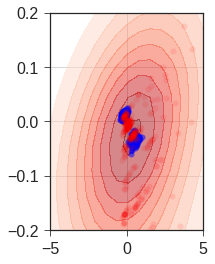

In [242]:
pca = PCA(n_components=2)
pca_vis = pca.fit_transform(x_train0)
sns.plt.subplot(1,2,1)
sns.kdeplot(pca_vis[y_train0 == 0, 0][:600], pca_vis[y_train0 == 0, 1][:600]
                ,cmap="Blues",shade=True, shade_lowest=False,alpha=0.8, cbar=True)
sns.kdeplot(pca_vis[y_train0 == 1, 0][:600], pca_vis[y_train0 == 1, 1][:600]
                ,cmap="Reds",shade=True, shade_lowest=False,alpha=0.5, cbar=True)

sns.plt.scatter(pca_vis[y_train0 == 0, 0][:600], pca_vis[y_train0 == 0, 1][:600]
                ,c="b",alpha=0.5)
sns.plt.scatter(pca_vis[y_train0 == 1, 0][:600], pca_vis[y_train0 == 1, 1][:600]
                ,c="r",alpha=0.1)
sns.plt.xlim(-5,5)
sns.plt.ylim(-0.2,0.2)
sns.plt.grid(True)



(-0.0, 0.15)

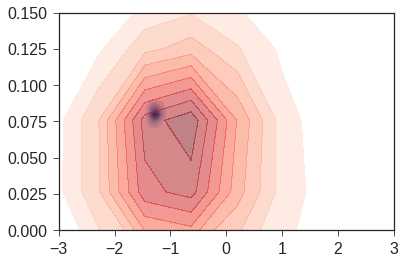

In [277]:
pca = PCA(n_components=2)
pca_vis = pca.fit_transform(X_train_res)
sns.kdeplot(pca_vis[y_train_res == 0, 0][:], pca_vis[y_train_res == 0, 1][:]
                ,cmap="Blues",shade=True, shade_lowest=False,alpha=1.0, cbar=True)
sns.kdeplot(pca_vis[y_train_res == 1, 0][:], pca_vis[y_train_res == 1, 1][:]
                ,cmap="Reds",shade=True, shade_lowest=False,alpha=0.5, cbar=True)

#sns.plt.scatter(pca_vis[y_train_res == 0, 0][:600], pca_vis[y_train_res == 0, 1][:600]
#                ,c="b",alpha=0.5)
#sns.plt.scatter(pca_vis[y_train_res == 1, 0][:600], pca_vis[y_train_res == 1, 1][:600]
#                ,c="r",alpha=0.1)
sns.plt.xlim(-3,3)
sns.plt.ylim(-0.0,0.15)

([], <a list of 0 Text xticklabel objects>)

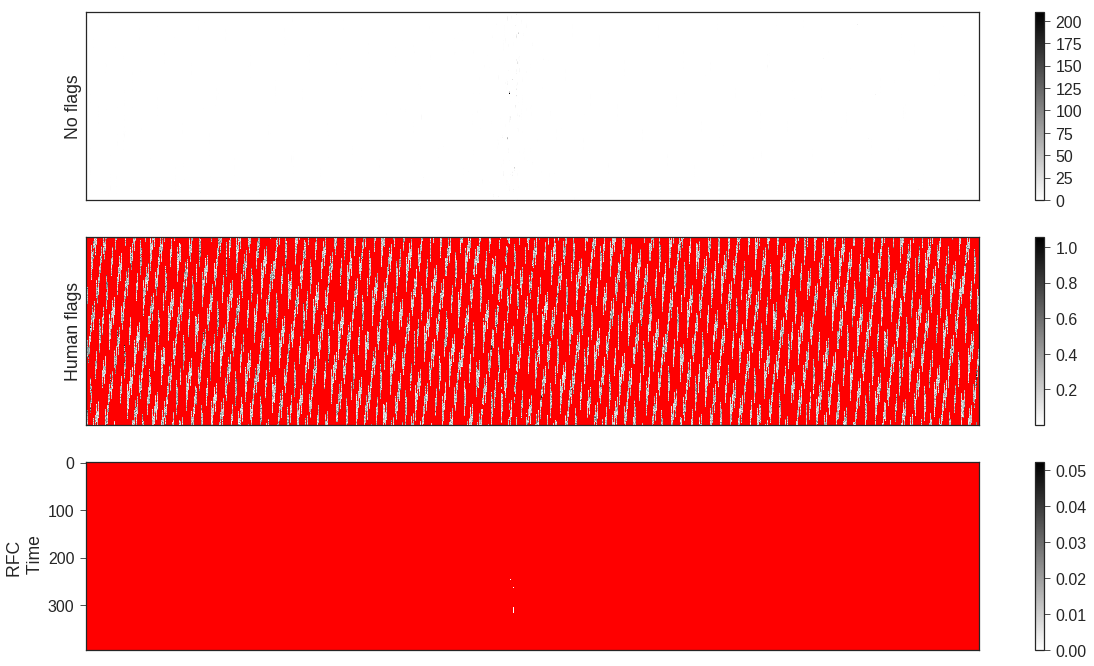

In [267]:
testVV = pd.DataFrame.from_csv('HHNGC641_NGC641_SAT_1~7_auto_rfi.ms_all_data_baseline1and8.csv')
testVV =  testVV.replace(np.nan,0)
rfi_rfc =clf.predict(testVV[best_features])
#rfi_knn = knn.predict(testVV[names])
#rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
#knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))
#gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))))


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(5,1,1)
sns.plt.imshow(image.T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(5,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags).T,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])



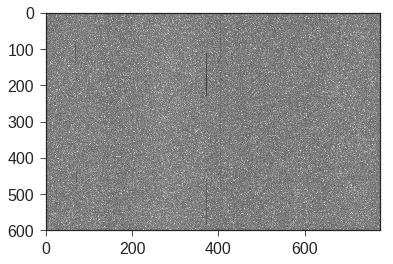

In [254]:
sns.plt.imshow(np.log10(image.T),aspect ='auto')

In [257]:
time = 0

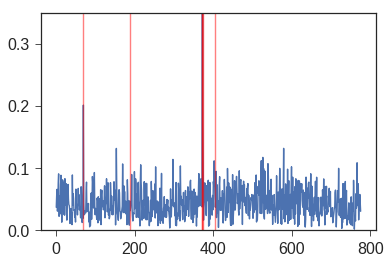

In [264]:
time = time + 40
sns.plt.figure()
#sns.plt.subplot("311")
sns.plt.plot((image[:,time]))
#sns.plt.xlabel("Channels")
#sns.plt.ylabel("Amplitude")
#sns.plt.xticks([])
sns.plt.ylim(0.0,0.35)
#sns.plt.plot(np.log10(np.mean(image[:,:],axis=1)))
for i in range(len(image[:,time])):
    if rfc_flags[i,time] == 1:
        sns.plt.axvline(i,alpha=0.5,color='r')
'''sns.plt.subplot("312")
sns.plt.plot((np.ma.array(image[:,time],mask=org_flags[:,time])))
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Amplitude")
sns.plt.xticks([])
#sns.plt.ylim(0.0,0.35)

sns.plt.subplot("313")
sns.plt.plot((np.ma.array(image[:,time],mask=rfc_flags[:,time]) - image[:,time]))
sns.plt.xlabel("Channels")
#sns.plt.ylabel("Amplitude")
#sns.plt.ylim(0.0,0.35)
'''

sns.plt.show()

In [269]:
def roc_plot(classifiers,subplot,model_names):
    #c = ['r','g','b']
    if subplot == True:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            sns.plt.subplot(1,num,i+1)
            clf = classifiers[i]
            y_roc_fpr, y_roc_tpr, y_roc_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roc_fpr, y_roc_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roc_fpr, y_roc_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    if subplot == False:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            clf = classifiers[i]
            y_roc_fpr, y_roc_tpr, y_roc_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roc_fpr, y_roc_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roc_fpr, y_roc_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    return

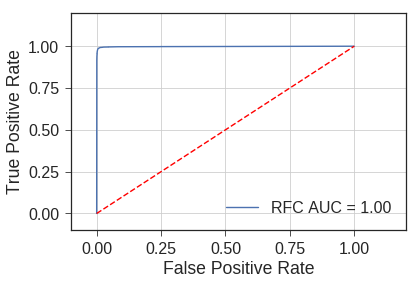

In [270]:
model_names =['RFC']
roc_plot([y_pred_prob_rfc],False,model_names)
sns.plt.grid(True)
#sns.plt.savefig("Results/HH/HH-ROC.png",dpi=300)
sns.plt.show()

([0.00024869760988507553,
  0.00025851462080159166,
  0.00028578409556969205,
  0.0003305060341893767,
  0.00034817665383910575,
  0.00036977407785544124,
  0.00038052604219257795,
  0.00038531767847325846,
  0.00036795611287090122,
  0.00037631875179978535],
 [0.0017775334432838556,
  0.0014339380612057907,
  0.0012308350131329791,
  0.0012186182884368702,
  0.0011086677661718894,
  0.0010872884979536985,
  0.0010231506932991265,
  0.00099871724390690865,
  0.00099413597214586765,
  0.00096970252275364974])

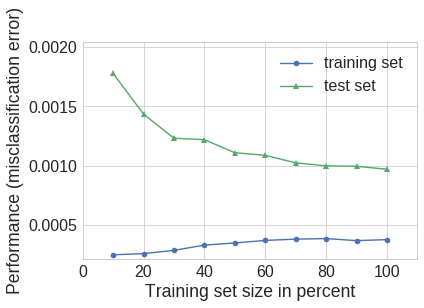

In [271]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, rfc
                     ,print_model=False,style="seaborn-whitegrid")

In [272]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=sns.plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #sns.plt.title(title)
    sns.plt.colorbar()
    tick_marks = np.arange(len(classes))
    sns.plt.xticks(tick_marks, classes, rotation=45)
    sns.plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        sns.plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    sns.plt.tight_layout()
    sns.plt.grid(False)
    sns.plt.ylabel('True label')
    sns.plt.xlabel('Predicted label')
    
def evaluate(model,modelname):
    #f = open("Results/HH/HH-Classification_report.txt","a+")
    for i in range(len(models)):
        # Do the actual prediction
        
        
        print('====================================================')
        print('Classification Report for %s'%modelname[i])
        print('====================================================')
        print(classification_report(y_test0,model[i],target_names=['Not RFI','RFI']))

        print('\n The model is %f accurate' %(accuracy_score(y_test0,model[i])*100))
        print('==================================================== \n')
        print('Classification Report for %s \n'%modelname[i])
        print('==================================================== \n')
        print(classification_report(y_test0,model[i],target_names=['Not RFI','RFI']))

        print('\n The model is %f accurate \n' %(accuracy_score(y_test0,model[i])*100))
        print('Confusion Matrix')
        cnf_matrix = confusion_matrix(y_test0,model[i])
        sns.plt.figure()
        #sns.plt.subplot(1,3,i+1)
        plot_confusion_matrix(cnf_matrix, classes=target_names)
                      #title='Confusion matrix')
        #sns.plt.savefig("Results/HH/HH-"+str(modelname[i])+"_learning_curve.png",dpi=300)
        #sns.plt.subplot(2,1,2)
        #plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True
        #                      ,title='Normalized confusion matrix')
        print('====================================================\n\n')
    #f.close()

Classification Report for RFC
             precision    recall  f1-score   support

    Not RFI       1.00      1.00      1.00    649708
        RFI       0.93      0.92      0.93      5132

avg / total       1.00      1.00      1.00    654840


 The model is 99.887912 accurate

Classification Report for RFC 


             precision    recall  f1-score   support

    Not RFI       1.00      1.00      1.00    649708
        RFI       0.93      0.92      0.93      5132

avg / total       1.00      1.00      1.00    654840


 The model is 99.887912 accurate 

Confusion Matrix




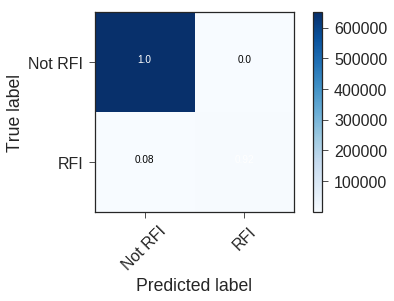

In [274]:
models =[y_pred_rfc]
model_names =['RFC']
#sns.plt.figure(figsize=(20,20))
evaluate(models,model_names)
sns.plt.show()

In [ ]:
c